In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wrangle
import prepare_ravinder
from sklearn.model_selection import train_test_split
# ignore warnings
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve
sns.set()
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)
from sklearn.preprocessing import MinMaxScaler
import itertools
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SMOTE

import time
from lightgbm import LGBMClassifier
import lightgbm as lgb

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline


In [2]:
import gc
gc.enable()

# Load Data

In [39]:
df = pd.read_csv('data/training_v2.csv')
id_col = 'encounter_id'

df1 = pd.read_csv('data/WiDS Datathon 2020 Dictionary.csv')
df_obj = df1[(df1['Data Type'] == 'string') | (df1['Data Type'] == 'binary')]
cat_features = list(df_obj['Variable Name'].values)
for c in cat_features:
    if c not in df1.columns or c == 'hospital_death':
        cat_features.remove(c)
print(f'cat_features: {cat_features}')

cat_features: ['bmi', 'ethnicity', 'hospital_admit_source', 'icu_admit_type', 'icu_type', 'apache_2_diagnosis', 'apache_post_operative', 'gcs_unable_apache', 'ventilated_apache', 'cirrhosis', 'hepatic_failure', 'leukemia', 'solid_tumor_with_metastasis', 'apache_2_bodysystem']


In [40]:
df3 = pd.read_csv('data/training_v2.csv')
df['gcs'] = df.gcs_eyes_apache + df.gcs_motor_apache + df.gcs_verbal_apache

In [41]:
df.apache_2_bodysystem = np.where(df.apache_2_bodysystem == 'Undefined diagnoses', 'Undefined Diagnoses', df.apache_2_bodysystem)
df.apache_2_bodysystem = np.where(df.apache_2_bodysystem == 'Undefined Diagnoses', 'Undefined Diagnosis', df.apache_2_bodysystem)



In [6]:
train, test = train_test_split(df, train_size = .80, random_state = 42, stratify = df.hospital_death)

In [43]:
X = df.drop(columns = ['hospital_death'])
y = df[['hospital_death']]

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = .80, random_state = 42, stratify = df.hospital_death)

In [18]:
# train['log_bmi'] = np.log2(train.bmi)
# # train['log_age'] = np.log2(train.age)

In [45]:
mapping = dict(hospital_deaths[['hospital_id', 'hospital_death']].values)
train['hospital_death_average'] = train.hospital_id.map(mapping)
train.head(2)

NameError: name 'hospital_deaths' is not defined

## Which patients are most likely to Survive/Not-survive

In [20]:
X_train.head(2)

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,gcs
59226,44014,57225,176,72.0,32.041330,0,Caucasian,F,154.9,Step-Down Unit (SDU),Floor,628,admit,MICU,0.061111,0,76.88,2.0,113.0,501.02,0,0.0,2.4,26.0,1.64,NaN,4.0,6.0,0.0,4.0,107.0,99.0,27.9,0.0,45.0,NaN,NaN,NaN,NaN,13.0,135.0,36.6,NaN,0.0,22.81,NaN,NaN,95.0,13.0,95.0,13.0,150.0,77.0,NaN,NaN,101.0,22.0,101.0,22.0,40.0,12.0,100.0,38.0,NaN,NaN,161.0,48.0,161.0,48.0,36.7,35.8,NaN,NaN,51.0,39.0,51.0,39.0,94.0,92.0,NaN,NaN,59.0,47.0,59.0,47.0,19.0,16.0,98.0,96.0,NaN,NaN,85.0,72.0,85.0,72.0,NaN,NaN,2.0,2.0,2.4,2.4,26.0,26.0,7.1,7.1,1.64,1.64,132.0,107.0,20.0,20.0,13.7,8.8,43.6,27.9,1.8,1.8,2.6,2.6,81.0,81.0,4.1,4.1,135.0,135.0,22.81,22.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.8,1.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.22,0.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Sepsis,Cardiovascular,14.0
81334,115047,127855,18,58.0,34.334291,0,Caucasian,M,190.5,Direct Admit,Accident & Emergency,804,admit,M

In [21]:
# Exploration by Diagnosis(apache_3j_diagnosis)
train.apache_2_bodysystem.value_counts()

Cardiovascular         31033
Neurologic              9576
Respiratory             9283
Gastrointestinal        7220
Metabolic               6101
Undefined Diagnosis     3256
Trauma                  3084
Renal/Genitourinary     1968
Haematologic             503
Name: apache_2_bodysystem, dtype: int64

In [22]:
train.groupby('apache_2_bodysystem').hospital_death.mean()

apache_2_bodysystem
Cardiovascular         0.107692
Gastrointestinal       0.074238
Haematologic           0.095427
Metabolic              0.014260
Neurologic             0.078739
Renal/Genitourinary    0.057927
Respiratory            0.113972
Trauma                 0.066472
Undefined Diagnosis    0.023342
Name: hospital_death, dtype: float64

In [23]:
daignosis_df = pd.DataFrame(train.groupby('apache_3j_diagnosis').hospital_death.mean()).reset_index()

In [24]:
daignosis_df.sort_values()

TypeError: sort_values() missing 1 required positional argument: 'by'

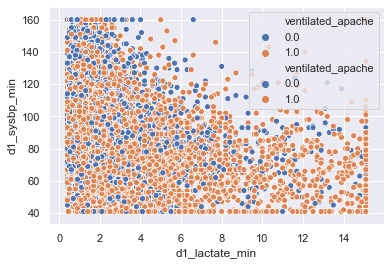

In [25]:
df_s = df[df.hospital_death == 0]
df_d = df[df.hospital_death == 1]
sns.scatterplot(x = 'd1_lactate_min', y = 'd1_sysbp_min', data = df_s, hue = 'ventilated_apache')
sns.scatterplot(x = 'd1_lactate_min', y = 'd1_sysbp_min', data = df_d, hue = 'ventilated_apache')

In [26]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import time
from lightgbm import LGBMClassifier
import lightgbm as lgb

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

import warnings
warnings.simplefilter('ignore', UserWarning)

import gc
gc.enable()

In [46]:
categorical_feats = [
    f for f in X_train.columns if X_train[f].dtype == 'object'
]

# categorical_feats =
for f_ in categorical_feats:
    X_train[f_], _ = pd.factorize(X_train[f_])
    # Set feature type as categorical
    X_train[f_] = X_train[f_].astype('category')

In [47]:
def get_feature_importances(data, shuffle,y, seed=None):
    # Gather real features
    train_features = [f for f in data]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
#     y = data['TARGET'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = y['hospital_death'].copy().sample(frac=1.0)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(train[train_features], y, free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'rf',
        'subsample': 0.623,
        'colsample_bytree': 0.7,
        'num_leaves': 127,
        'max_depth': 8,
        'seed': seed,
        'bagging_freq': 1,
        'n_jobs': 4
    }
    
    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200, categorical_feature=categorical_feats)

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')

    imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]))
    
    return imp_df

In [48]:
# Seed the unexpected randomness of this world
np.random.seed(123)
# Get the actual importance, i.e. without shuffling
actual_imp_df = get_feature_importances(data=X_train, y = y_train,shuffle=False)

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: ethnicity, gender, hospital_admit_source, icu_admit_source, icu_stay_type, icu_type, apache_3j_bodysystem, apache_2_bodysystem

In [34]:
actual_imp_df

NameError: name 'actual_imp_df' is not defined

In [15]:
null_imp_df = pd.DataFrame()
nb_runs = 80
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=X_train, y = y_train, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

NameError: name 'X_train' is not defined

In [1]:
null_imp_df.head(50)

NameError: name 'null_imp_df' is not defined

In [222]:
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_split'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_split'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Split Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for %s ' % feature_.upper())
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())
        

In [23]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='leukemia')

NameError: name 'display_distributions' is not defined

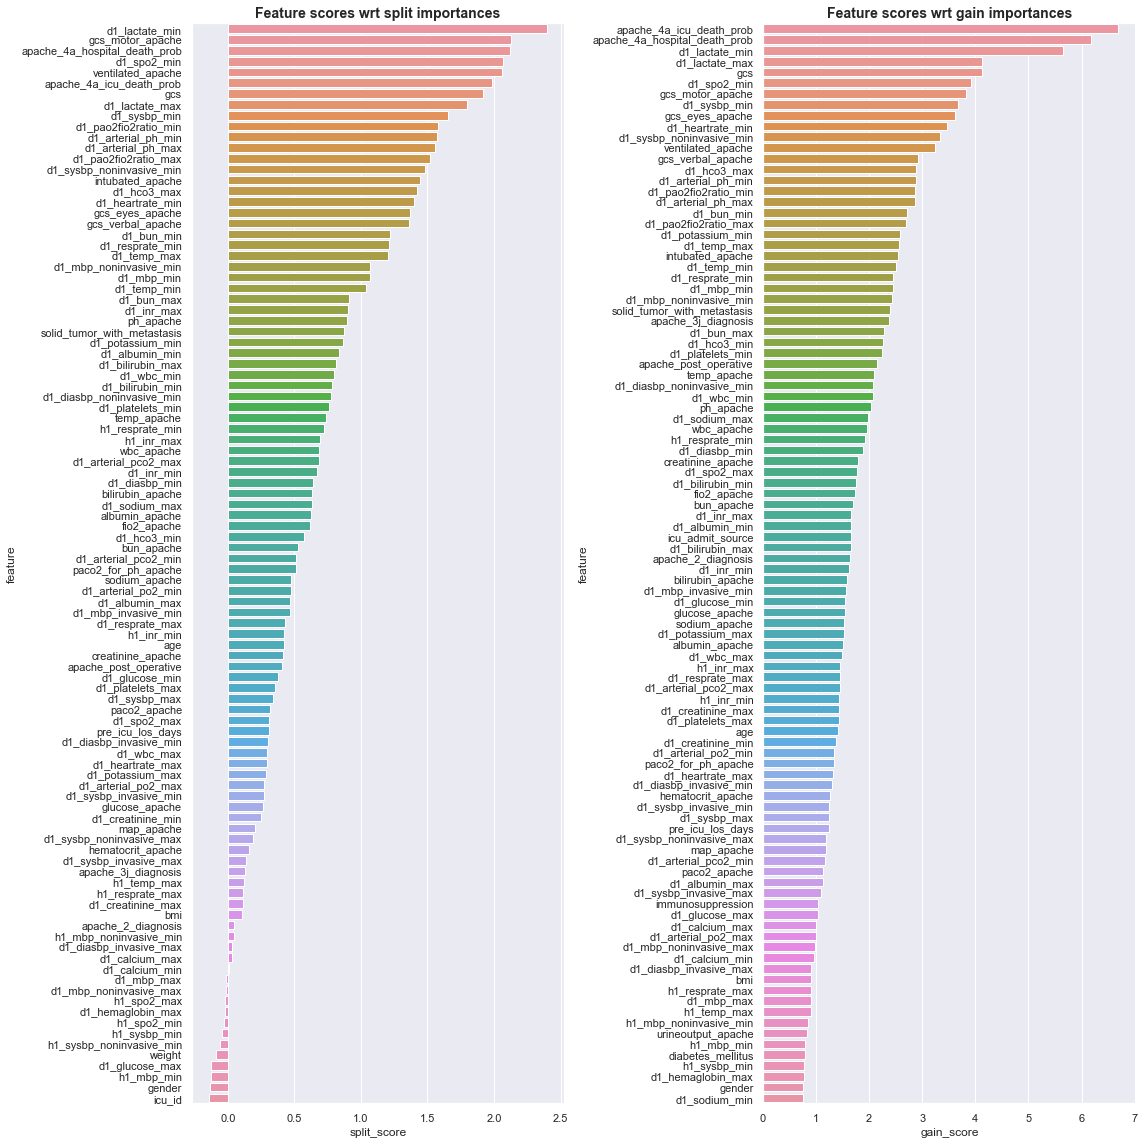

In [233]:
# In a first step I will use the log actual feature importance divided by the 75 percentile of null distribution
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:100], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:100], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

In [228]:
# Save data
null_imp_df.to_csv('null_importances_distribution_rf.csv')
actual_imp_df.to_csv('actual_importances_ditribution_rf.csv')

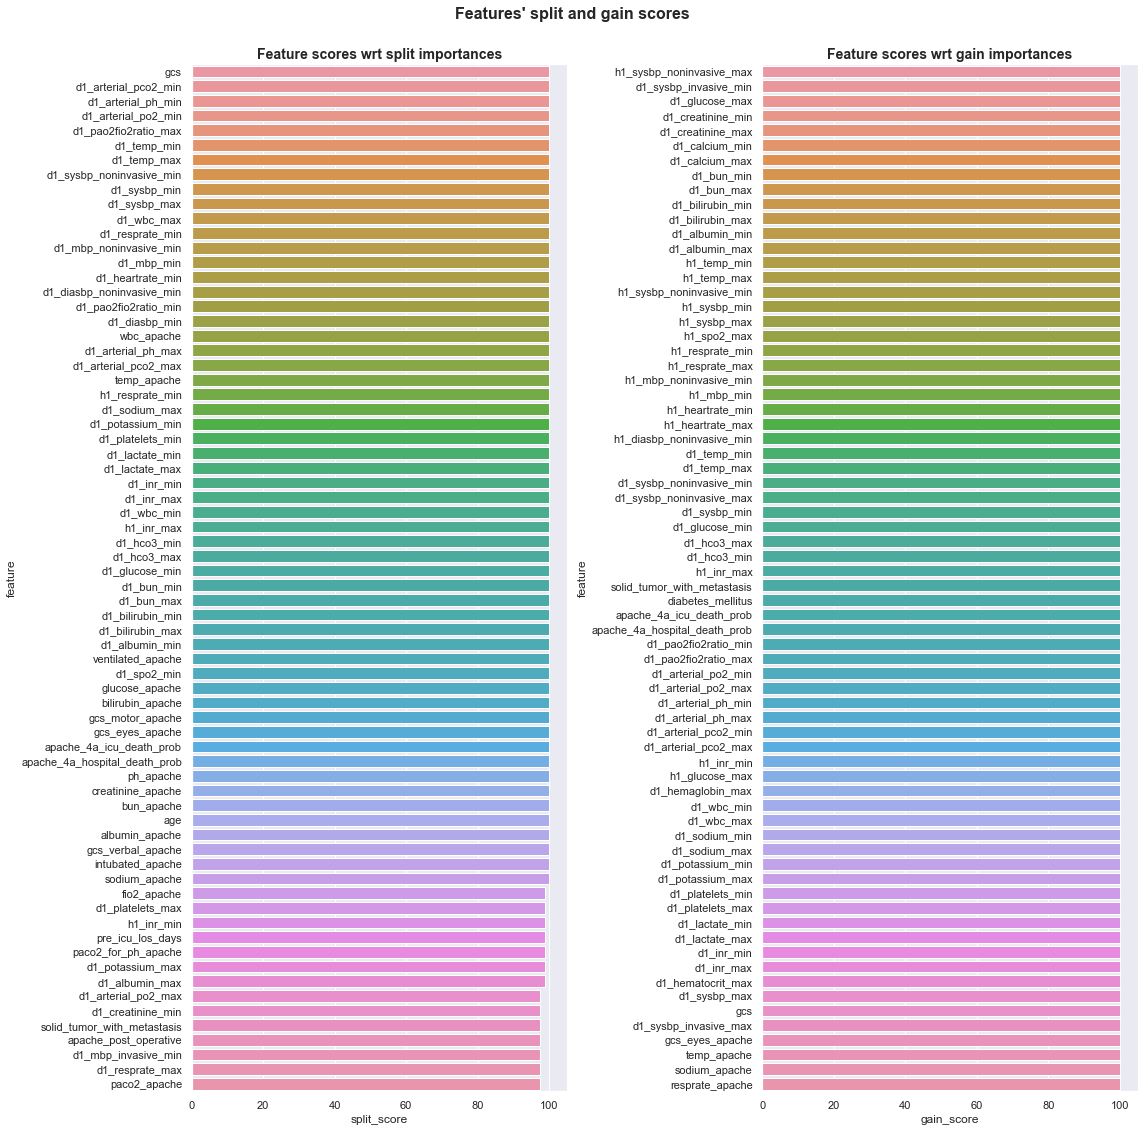

In [229]:
#Check the impact of removing uncorrelated features
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

In [232]:
def score_feature_selection(df=None, train_features=None, cat_feats=None, target=None):
    # Fit LightGBM 
    dtrain = lgb.Dataset(df[train_features], target, free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'learning_rate': .1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'num_leaves': 31,
        'max_depth': -1,
        'seed': 13,
        'n_jobs': 4,
        'min_split_gain': .00001,
        'reg_alpha': .00001,
        'reg_lambda': .00001,
        'metric': 'auc'
    }
    
    # Fit the model
    hist = lgb.cv(
        params=lgb_params, 
        train_set=dtrain, 
        num_boost_round=2000,
        categorical_feature=cat_feats,
        nfold=5,
        stratified=True,
        shuffle=True,
        early_stopping_rounds=50,
        verbose_eval=0,
        seed=17
    )
    # Return the last mean / std values 
    return hist['auc-mean'][-1], hist['auc-stdv'][-1]

# features = [f for f in data.columns if f not in ['SK_ID_CURR', 'TARGET']]
# score_feature_selection(df=data[features], train_features=features, target=data['TARGET'])

for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
                                                                                             
    print('Results for threshold %3d' % threshold)
    split_results = score_feature_selection(df=X_train, train_features=split_feats, cat_feats=split_cat_feats, target= y_train['hospital_death'])
    print('\t SPLIT : %.6f +/- %.6f' % (split_results[0], split_results[1]))
    gain_results = score_feature_selection(df=X_train, train_features=gain_feats, cat_feats=gain_cat_feats, target= y_train['hospital_death'])
    print('\t GAIN  : %.6f +/- %.6f' % (gain_results[0], gain_results[1]))

Results for threshold   0
	 SPLIT : 0.899087 +/- 0.002653
	 GAIN  : 0.899087 +/- 0.002653
Results for threshold  10
	 SPLIT : 0.899617 +/- 0.003306
	 GAIN  : 0.899517 +/- 0.003343
Results for threshold  20
	 SPLIT : 0.899403 +/- 0.003369
	 GAIN  : 0.899614 +/- 0.003241
Results for threshold  30
	 SPLIT : 0.899001 +/- 0.003280
	 GAIN  : 0.899614 +/- 0.003241
Results for threshold  40
	 SPLIT : 0.898033 +/- 0.003061
	 GAIN  : 0.899541 +/- 0.003146
Results for threshold  50
	 SPLIT : 0.897625 +/- 0.003441
	 GAIN  : 0.899705 +/- 0.003592
Results for threshold  60
	 SPLIT : 0.897866 +/- 0.003780
	 GAIN  : 0.898834 +/- 0.002622
Results for threshold  70
	 SPLIT : 0.897153 +/- 0.002649
	 GAIN  : 0.900068 +/- 0.002269
Results for threshold  80
	 SPLIT : 0.897586 +/- 0.003261
	 GAIN  : 0.900032 +/- 0.002462
Results for threshold  90
	 SPLIT : 0.897172 +/- 0.002415
	 GAIN  : 0.899972 +/- 0.002832
Results for threshold  95
	 SPLIT : 0.895789 +/- 0.003057
	 GAIN  : 0.899584 +/- 0.002793
Results fo

In [88]:
df.isnull().sum().sort_values(ascending = False).head(10)

h1_bilirubin_min        84619
h1_bilirubin_max        84619
h1_lactate_max          84369
h1_lactate_min          84369
h1_albumin_min          83824
h1_albumin_max          83824
h1_pao2fio2ratio_min    80195
h1_pao2fio2ratio_max    80195
h1_arterial_ph_max      76424
h1_arterial_ph_min      76424
dtype: int64

In [89]:
missing = ['h1_bilirubin_min', 'h1_bilirubin_max', 'h1_lactate_max',
       'h1_lactate_min', 'h1_albumin_min', 'h1_albumin_max',
       'h1_pao2fio2ratio_min', 'h1_pao2fio2ratio_max', 'h1_arterial_ph_max',
       'h1_arterial_ph_min', 'h1_hco3_max', 'h1_hco3_min',
       'h1_arterial_pco2_max', 'h1_arterial_pco2_min', 'h1_wbc_max',
       'h1_wbc_min', 'h1_arterial_po2_min', 'h1_arterial_po2_max',
       'h1_calcium_max', 'h1_calcium_min', 'h1_platelets_min',
       'h1_platelets_max', 'h1_bun_max', 'h1_bun_min', 'h1_creatinine_max',
       'h1_creatinine_min', 'h1_hematocrit_min', 'h1_hematocrit_max',
       'h1_hemaglobin_min', 'h1_hemaglobin_max', 'h1_sodium_max',
       'h1_sodium_min', 'h1_potassium_min', 'h1_potassium_max']

In [ ]:
# features missing > x% values
df[df.]

In [90]:
# m = [missing[2],missing[16],missing[13],missing[4],missing[27],missing[11],missing[7]]
m = ['h1_lactate_max',
 'h1_arterial_po2_min',
 'h1_arterial_pco2_min',
 'h1_albumin_min',
 'h1_hematocrit_max',
 'h1_hco3_min',
 'h1_pao2fio2ratio_max']

In [91]:
 df[['d1_arterial_pco2_max',
 'd1_arterial_pco2_min',
 'd1_arterial_ph_max',
 'd1_arterial_ph_min',
 'd1_arterial_po2_max',
 'd1_arterial_po2_min',
 'd1_pao2fio2ratio_max',
 'd1_pao2fio2ratio_min',
 'h1_arterial_pco2_max',
 'h1_arterial_pco2_min',
 'h1_arterial_ph_max',
 'h1_arterial_ph_min',
 'h1_arterial_po2_max',
 'h1_arterial_po2_min',
 'h1_pao2fio2ratio_max',
 'h1_pao2fio2ratio_min',
 'apache_4a_hospital_death_prob',
 'apache_4a_icu_death_prob',
  'h1_hco3_max',
 'h1_hco3_min',
 'h1_hemaglobin_max',
 'h1_hemaglobin_min',
 'h1_hematocrit_max',
 'h1_hematocrit_min',
 'h1_inr_max',
 'h1_inr_min',
 'h1_lactate_max',
 'h1_lactate_min',
 'hospital_death',
 'age',
 'bmi',
  'height',
 'pre_icu_los_days',
 'readmission_status',
 'weight',
 'albumin_apache',
 'arf_apache',
 'bilirubin_apache',
 'bun_apache',
 'creatinine_apache',
 'fio2_apache',
 'gcs',
 'heart_rate_apache',
 'hematocrit_apache',
 'intubated_apache',
 'map_apache',
 'paco2_apache',
 'paco2_for_ph_apache',
 'pao2_apache',
 'ph_apache',
 'resprate_apache',
 'sodium_apache',
 'temp_apache',
 'urineoutput_apache',
 'ventilated_apache',
 'wbc_apache',
]].isna().sum()

d1_arterial_pco2_max             59271
d1_arterial_pco2_min             59271
d1_arterial_ph_max               60123
d1_arterial_ph_min               60123
d1_arterial_po2_max              59262
d1_arterial_po2_min              59262
d1_pao2fio2ratio_max             66008
d1_pao2fio2ratio_min             66008
h1_arterial_pco2_max             75959
h1_arterial_pco2_min             75959
h1_arterial_ph_max               76424
h1_arterial_ph_min               76424
h1_arterial_po2_max              75945
h1_arterial_po2_min              75945
h1_pao2fio2ratio_max             80195
h1_pao2fio2ratio_min             80195
apache_4a_hospital_death_prob     7947
apache_4a_icu_death_prob          7947
h1_hco3_max                      76094
h1_hco3_min                      76094
h1_hemaglobin_max                73123
h1_hemaglobin_min                73123
h1_hematocrit_max                73420
h1_hematocrit_min                73420
h1_inr_max                       57941
h1_inr_min               

In [10]:
# df[((df.gcs <= 5) & (df.ventilated_apache ==1) & (df.intubated_apache == 1) & (df.resprate_apache > 30))].hospital_death.value_counts()

In [11]:
# df[((df.gcs <= 5) & (df.ventilated_apache ==1))].hospital_death.value_counts()

In [12]:
# df[((df.gcs <= 5) & (df.ventilated_apache == 1)) & df.d1_temp_max < 35 & df.d1_temp_max.notnull()].hospital_death.value_counts()


In [13]:
# df.groupby('hospital_death').h1_arterial_pco2_max.count()

In [14]:
# df.groupby('hospital_death').h1_arterial_pco2_max.count()[0]/df[(df.hospital_death == 0)].shape[0]

In [15]:
# df.groupby('hospital_death').h1_arterial_pco2_max.count()[1]/df[(df.hospital_death == 1)].shape[0]

In [16]:
# df[(df.hospital_death == 1) & (df.h1_arterial_pco2_max.notnull())].shape


In [17]:
# df[(df.hospital_death == 0) & (df.h1_arterial_pco2_max.isnull())].shape


In [94]:
df.head(2)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,gcs
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0.0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,0.0,14.1,46.0,32.0,68.0,37.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0,73.0,131.0,73.0,39.9,37.2,NaN,NaN,68.0,63.0,68.0,63.0,119.0,108.0,NaN,NaN,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,NaN,NaN,131.0,115.0,131.0,115.0,39.5,37.5,2.3,2.3,0.4,0.4,31.0,30.0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,NaN,NaN,1.3,1.0,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,13.0
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,7

In [153]:
df[df.apache_3j_diagnosis ==102.01].hospital_death.value_counts()

1    1125
0    1114
Name: hospital_death, dtype: int64

In [10]:
diagnosis_codes = df.apache_3j_diagnosis.value_counts().index.to_list()

In [143]:
diagnosis_codes[0]

501.05

In [116]:
diag = pd.DataFrame( columns = ['diagnosis', 'died', 'survived','ratio'])
# dict= {'d': '', 'died': '', 'ratio': ''}
for i in range(0, len(diagnosis_codes)):
    died = df[df.apache_3j_diagnosis== diagnosis_codes[i]][df.hospital_death ==1].shape[0]
#     print(died)
    survived = df[df.apache_3j_diagnosis== diagnosis_codes[i]][df.hospital_death ==0].shape[0]
    ratio = round(died/survived,2)
    diag = diag.append({'diagnosis': diagnosis_codes[i] , 'died': died, 'survived': survived, 'ratio': ratio}, ignore_index = True)


In [119]:
diag['died'] = diag['died'].astype(int)
diag['survived'] = diag['survived'].astype(int)

In [144]:
diag.iloc[8,0] = 'Cardiac arrest'
diag.iloc[0,0] = 'Pulmonary sepsis'
diag.iloc[3,0] = 'Stroke'
diag.iloc[5,0] = 'Heart failure'
diag.iloc[14,0] = 'GI sepsis'

diag.iloc[10,0] = 'Pneumonia'
diag.iloc[6,0] =  'UTI Sepsis'
diag.iloc[22,0] = 'Respiratory arrest'
diag.iloc[19,0] = 'Unknown Sepsis'
diag.iloc[20,0] = 'Brain Haemorrhage'

In [167]:
diag_sorted = diag.sort_values(by = [ 'died'], ascending = False).head(10)
diag_sorted

,diagnosis,died,survived,ratio
8,Cardiac arrest,1125,1114,1.01
0,Pulmonary sepsis,804,3677,0.22
3,Stroke,349,3440,0.10
5,Heart failure,319,2637,0.12
14,GI sepsis,306,1169,0.26
10,Pneumonia,303,1694,0.18
6,UTI Sepsis,298,2544,0.12
22,Respiratory arrest,232,945,0.25
19,Unknown Sepsis,218,1027,0.21
20,Brain Haemorrhage,217,1026,0.21


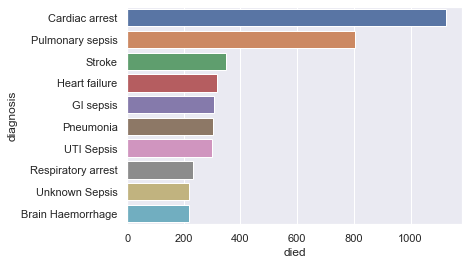

In [160]:
ax = sns.barplot(y = 'diagnosis', x = 'died', data = diag_sorted)

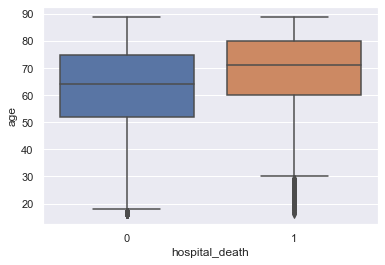

In [164]:
sns.boxplot(y = 'age', x = 'hospital_death', data = train)

In [190]:
train.head(2)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,gcs
59226,44014,57225,176,1,72.0,32.041330,0,Caucasian,F,154.9,Step-Down Unit (SDU),Floor,628,admit,MICU,0.061111,0,76.88,2.0,113.0,501.02,0,0.0,2.4,26.0,1.64,NaN,4.0,6.0,0.0,4.0,107.0,99.0,27.9,0.0,45.0,NaN,NaN,NaN,NaN,13.0,135.0,36.6,NaN,0.0,22.81,NaN,NaN,95.0,13.0,95.0,13.0,150.0,77.0,NaN,NaN,101.0,22.0,101.0,22.0,40.0,12.0,100.0,38.0,NaN,NaN,161.0,48.0,161.0,48.0,36.7,35.8,NaN,NaN,51.0,39.0,51.0,39.0,94.0,92.0,NaN,NaN,59.0,47.0,59.0,47.0,19.0,16.0,98.0,96.0,NaN,NaN,85.0,72.0,85.0,72.0,NaN,NaN,2.0,2.0,2.4,2.4,26.0,26.0,7.1,7.1,1.64,1.64,132.0,107.0,20.0,20.0,13.7,8.8,43.6,27.9,1.8,1.8,2.6,2.6,81.0,81.0,4.1,4.1,135.0,135.0,22.81,22.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.8,1.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.22,0.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Sepsis,Cardiovascular,14.0
81334,115047,127855,18,0,58.0,34.334291,0,Caucasian,M,190.5,Direct Admit,Accident & Em

In [166]:
df.gcs.isnull().sum()

1901

In [ ]:
def get_feature_importances(data, shuffle, seed=None):
    # Gather real features
    train_features = [f for f in data if f not in ['TARGET', 'SK_ID_CURR']]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
    y = data['TARGET'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['TARGET'].copy().sample(frac=1.0)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data[train_features], y, free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'rf',
        'subsample': 0.623,
        'colsample_bytree': 0.7,
        'num_leaves': 127,
        'max_depth': 8,
        'seed': seed,
        'bagging_freq': 1,
        'n_jobs': 4
    }
    
    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200, categorical_feature=categorical_feats)

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]))
    
    return imp_df

In [ ]:
d_train = lgb.Dataset(x_train, label=y_train)
params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10
clf = lgb.train(params, d_train, 100)

In [113]:
df[df.apache_3j_diagnosis== 502.01][df.hospital_death ==1].shape[0]/df[df.apache_3j_diagnosis== 502.01][df.hospital_death ==0].shape[0]

0.11713836477987422

In [18]:
df[df.d1_sysbp_invasive_max.notnull()].hospital_death.value_counts()

0    20756
1     2998
Name: hospital_death, dtype: int64

In [19]:
df[df.h1_sysbp_invasive_max.isnull()].hospital_death.value_counts()

0    68275
1     6640
Name: hospital_death, dtype: int64

In [20]:
df[(df.ph_apache <7.3) & (df.d1_sysbp_invasive_max.notnull())].hospital_death.value_counts()

0    1544
1     919
Name: hospital_death, dtype: int64

In [21]:
df[((df.h1_lactate_max) < (df.d1_lactate_max)) | (df.h1_inr_max > df.d1_inr_max)].hospital_death.value_counts()

0    1004
1     461
Name: hospital_death, dtype: int64

In [22]:
df.apache_3j_bodysystem.value_counts()

Cardiovascular          29999
Neurological            11896
Sepsis                  11740
Respiratory             11609
Gastrointestinal         9026
Metabolic                7650
Trauma                   3842
Genitourinary            2172
Musculoskeletal/Skin     1166
Hematological             638
Gynecological             313
Name: apache_3j_bodysystem, dtype: int64

In [23]:
df.apache_2_bodysystem.value_counts()

Cardiovascular         38816
Neurologic             11896
Respiratory            11609
Gastrointestinal        9026
Metabolic               7650
Trauma                  3842
Undefined diagnoses     3768
Renal/Genitourinary     2460
Haematologic             638
Undefined Diagnoses      346
Name: apache_2_bodysystem, dtype: int64

In [24]:
df.apache_2_diagnosis.value_counts()

113.0    11740
301.0     6807
302.0     6702
112.0     4350
308.0     4114
117.0     3923
124.0     3906
122.0     3768
303.0     3329
110.0     3206
304.0     3104
203.0     2631
202.0     2481
106.0     2476
305.0     2275
114.0     2257
121.0     2215
123.0     2064
102.0     1883
307.0     1818
119.0     1721
120.0     1377
118.0     1355
108.0     1177
214.0     1167
109.0     1071
105.0     1037
213.0      750
207.0      643
306.0      638
218.0      553
217.0      483
209.0      480
219.0      461
101.0      376
104.0      363
103.0      291
115.0      251
116.0      204
107.0      197
215.0      159
208.0      123
212.0       99
216.0       26
Name: apache_2_diagnosis, dtype: int64

In [25]:
df

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,gcs
0,66154,25312,118,0,68.0,22.730000,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0.0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,0.0,14.10,46.0,32.0,68.0,37.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0,73.0,131.0,73.0,39.9,37.2,NaN,NaN,68.0,63.0,68.0,63.0,119.0,108.0,NaN,NaN,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,NaN,NaN,131.0,115.0,131.0,115.0,39.5,37.5,2.3,2.3,0.4,0.4,31.0,30.0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,NaN,NaN,1.3,1.0,233.0,233.0,4.0,3.4,136.0,134.0,14.10,14.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,13.0
1,114252,59342,81,0,77.0,27.420000,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0

In [26]:
df = df[df.apache_2_diagnosis.notnull()]
df.head(2)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,gcs
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0.0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,0.0,14.1,46.0,32.0,68.0,37.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0,73.0,131.0,73.0,39.9,37.2,NaN,NaN,68.0,63.0,68.0,63.0,119.0,108.0,NaN,NaN,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,NaN,NaN,131.0,115.0,131.0,115.0,39.5,37.5,2.3,2.3,0.4,0.4,31.0,30.0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,NaN,NaN,1.3,1.0,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,13.0
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,7

In [27]:
m = ['h1_lactate_max']

In [28]:
for m in m:
    df['bool_'+ m] = np.where(pd.notnull(df[m]), 1,0)

In [29]:
diagnosis = df.apache_2_diagnosis.value_counts().index
diagnosis = diagnosis.astype(str)

In [30]:
apache = [
 'age',
 'bmi',
 'height',
 'weight',
 'albumin_apache',
 'arf_apache',
 'bilirubin_apache',
 'bun_apache',
 'creatinine_apache',
 'fio2_apache',
 'glucose_apache',
 'heart_rate_apache',
 'hematocrit_apache',
 'intubated_apache',
 'map_apache',
 'paco2_apache',
 'paco2_for_ph_apache',
 'pao2_apache',
 'ph_apache',
 'resprate_apache',
 'sodium_apache',
 'temp_apache',
 'urineoutput_apache',
 'ventilated_apache',
 'wbc_apache',
 ]

In [31]:
df_ = pd.DataFrame(index=apache, columns= diagnosis)
# df_

In [32]:
for d in diagnosis:
    for a in apache:
        df_[d][a] = df[df.apache_2_diagnosis == float(d)][a].mean()


In [33]:
for a in apache:
    for d in diagnosis:
        df['diff_'+ a] = np.where(df[a].notnull(), df_[d][a]-df[a], 0)
        

In [34]:
df.head(2)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,...,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,gcs,bool_h1_lactate_max,diff_age,diff_bmi,diff_height,diff_weight,diff_albumin_apache,diff_arf_apache,diff_bilirubin_apache,diff_bun_apache,diff_creatinine_apache,diff_fio2_apache,diff_glucose_apache,diff_heart_rate_apache,diff_hematocrit_apache,diff_intubated_apache,diff_map_apache,diff_paco2_apache,diff_paco2_for_ph_apache,diff_pao2_apache,diff_ph_apache,diff_resprate_apache,diff_sodium_apache,diff_temp_apache,diff_urineoutput_apache,diff_ventilated_apache,diff_wbc_apache
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0.0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,0.0,14.1,46.0,32.0,68.0,37.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0,73.0,131.0,73.0,39.9,37.2,NaN,NaN,68.0,63.0,68.0,63.0,119.0,108.0,NaN,NaN,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,NaN,NaN,131.0,115.0,131.0,115.0,39.5,37.5,2.3,2.3,...,8.9,27.4,27.4,NaN,NaN,1.3,1.0,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [35]:
# df[df.cirrhosis == 1.0].hospital_death.value_counts()

In [36]:
# train[train.aids == 1.0].hospital_death.value_counts()[1]/train[train.aids == 1.0].hospital_death.value_counts()[0]/\
# train[train.aids == 0.0].hospital_death.value_counts()[1]/train[train.aids == 0.0].hospital_death.value_counts()[0]/a

In [37]:
# train[train.cirrhosis == 1.0].hospital_death.value_counts()[1]/train[train.cirrhosis == 1.0].hospital_death.value_counts()[0]\
# /train[train.cirrhosis == 0.0].hospital_death.value_counts()[1]/train[train.cirrhosis == 0.0].hospital_death.value_counts()[0]/a

In [38]:
# train[train.diabetes_mellitus == 1.0].hospital_death.value_counts()[1]/train[train.diabetes_mellitus == 1.0].hospital_death.value_counts()[0]\
# /train[train.diabetes_mellitus == 0.0].hospital_death.value_counts()[1]/train[train.diabetes_mellitus == 0.0].hospital_death.value_counts()[0]/a

In [39]:
# train[train.hepatic_failure == 1.0].hospital_death.value_counts()[1]/train[train.hepatic_failure == 1.0].hospital_death.value_counts()[0]\
# /train[train.hepatic_failure == 0.0].hospital_death.value_counts()[1]/train[train.hepatic_failure == 0.0].hospital_death.value_counts()[0]/a

In [40]:
# a = train[train.immunosuppression == 1.0].hospital_death.value_counts()[1]/train[train.immunosuppression == 1.0].hospital_death.value_counts()[0]\
# /train[train.immunosuppression == 0.0].hospital_death.value_counts()[0]/train[train.immunosuppression == 0.0].hospital_death.value_counts()[0]
# a

In [41]:
# train[train.leukemia == 1.0].hospital_death.value_counts()[1]/train[train.leukemia == 1.0].hospital_death.value_counts()[0]\
# /train[train.leukemia == 0.0].hospital_death.value_counts()[1]/train[train.leukemia == 0.0].hospital_death.value_counts()[0]/a

In [42]:
# train[train.lymphoma == 1.0].hospital_death.value_counts()[1]/train[train.lymphoma == 1.0].hospital_death.value_counts()[0]\
# /train[train.lymphoma == 0.0].hospital_death.value_counts()[1]/train[train.lymphoma == 0.0].hospital_death.value_counts()[0]/a

In [43]:
# train[train.solid_tumor_with_metastasis == 1.0].hospital_death.value_counts()[1]/train[train.solid_tumor_with_metastasis == 1.0].hospital_death.value_counts()[0]\
# /train[train.solid_tumor_with_metastasis == 0.0].hospital_death.value_counts()[1]/train[train.solid_tumor_with_metastasis == 0.0].hospital_death.value_counts()[0]/a

In [44]:
dfa = df[['hospital_death', 'bmi', 'age', 'gender','gcs', 'd1_lactate_min', 'ventilated_apache', 'fio2_apache', 'heart_rate_apache', 'hematocrit_apache', 'intubated_apache','map_apache','temp_apache', 'paco2_apache','pao2_apache', 'ph_apache', 'resprate_apache','sodium_apache']]
dfa = dfa.dropna()

In [45]:
# scaler1 = MinMaxScaler().fit(dfa)
# dfa_scaled_array = scaler1.transform(dfa)


In [46]:
df.h1_lactate_max.notnull().sum()

7238

In [47]:
df[df.h1_lactate_max.notnull()].hospital_death.value_counts()

0    5943
1    1295
Name: hospital_death, dtype: int64

In [62]:
df.d1_lactate_min.notnull().

0         True
1         True
2        False
3        False
4        False
         ...  
91708    False
91709     True
91710    False
91711    False
91712    False
Name: d1_lactate_min, Length: 90051, dtype: bool

In [63]:
df[df.d1_lactate_min.notnull()].hospital_death.value_counts()

0    19082
1     3954
Name: hospital_death, dtype: int64

In [65]:
df[df.d1_lactate_min.isnull()].hospital_death.value_counts()

0    63190
1     3825
Name: hospital_death, dtype: int64

In [79]:
df[(df.d1_lactate_min > 12) ].hospital_death.value_counts()

1    258
0     39
Name: hospital_death, dtype: int64

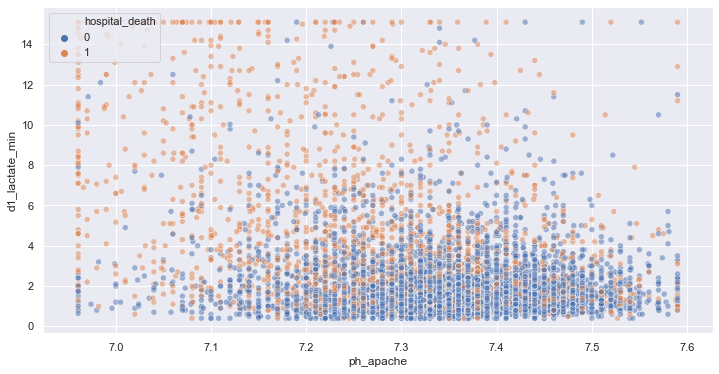

In [68]:
plt.figure(figsize = (12,6))
sns.scatterplot(x = 'ph_apache', y = 'd1_lactate_min', data = df, hue = 'hospital_death', alpha = 0.5)
# plt.grid()
plt.legend(loc='upper left')

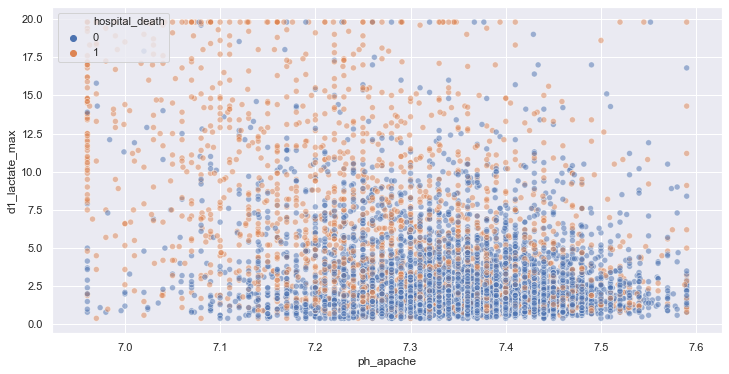

In [67]:
plt.figure(figsize = (12,6))
sns.scatterplot(x = 'ph_apache', y = 'd1_lactate_max', data = df, hue = 'hospital_death', alpha = 0.5)
# plt.grid()
plt.legend(loc='upper left')

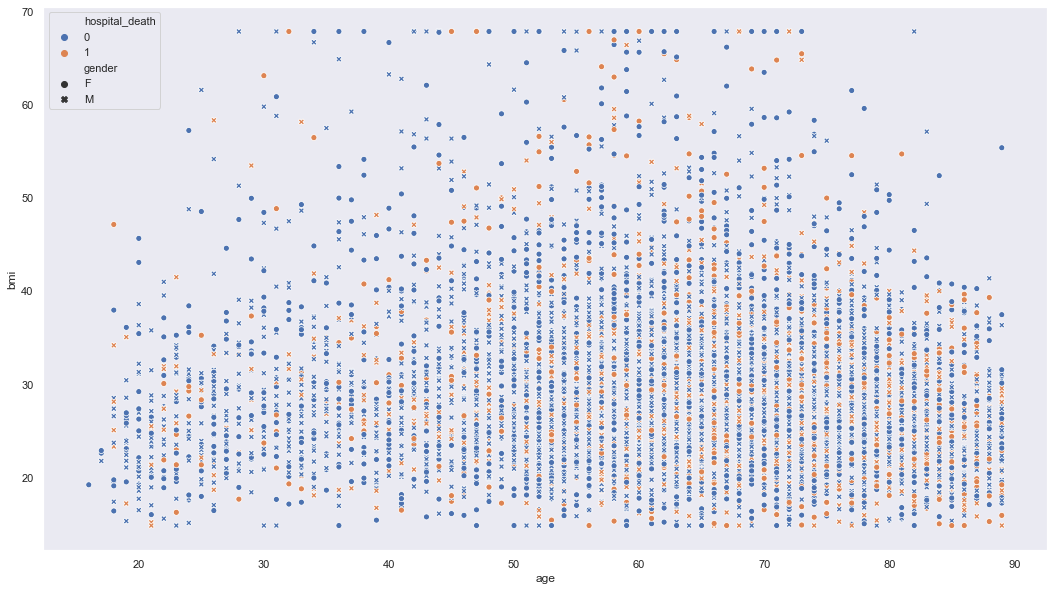

In [49]:
plt.figure(figsize = (18,10))
sns.scatterplot(x = 'age', y = 'bmi', data = dfa, hue = 'hospital_death', style = 'gender',alpha = 1.0)
plt.grid()
plt.legend(loc='upper left')

In [50]:
df[((df.age > 65) & (df.bmi < 30)) & (df.gender =='F' )].hospital_death.value_counts()

0    10751
1     1418
Name: hospital_death, dtype: int64

In [51]:
df[((df.age > 65) & (df.bmi < 30)) ].hospital_death.value_counts()[1]/df[((df.age > 65) & (df.bmi < 30)) ].hospital_death.value_counts()[0]



0.1299876768792759

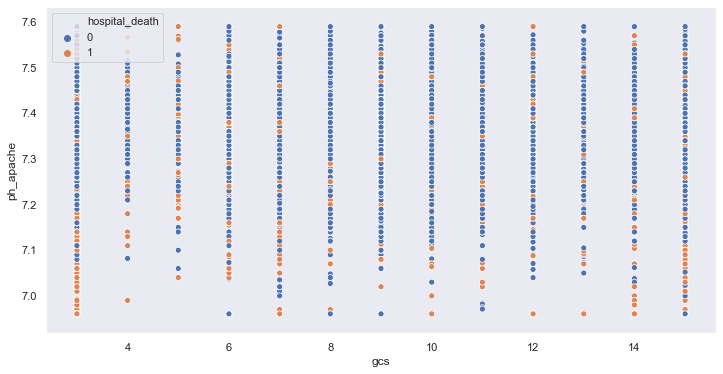

In [52]:
plt.figure(figsize = (12,6))
sns.scatterplot(x = 'gcs', y = 'ph_apache', data = dfa, hue = 'hospital_death')
plt.grid()
plt.legend(loc='upper left')

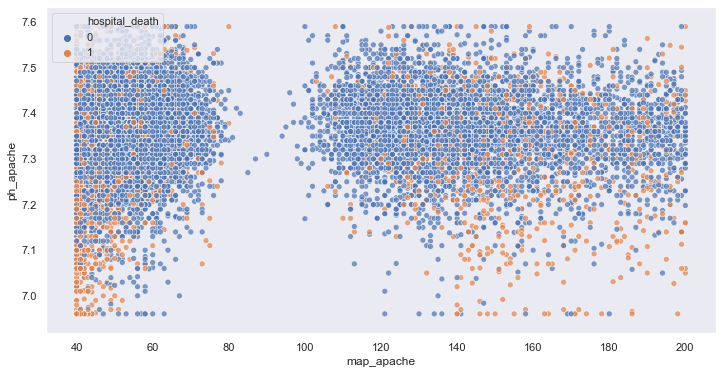

In [53]:
plt.figure(figsize = (12,6))
sns.scatterplot(x = 'map_apache', y = 'ph_apache', data = dfa, hue = 'hospital_death', alpha = 0.7)
plt.grid()
plt.legend(loc='upper left')

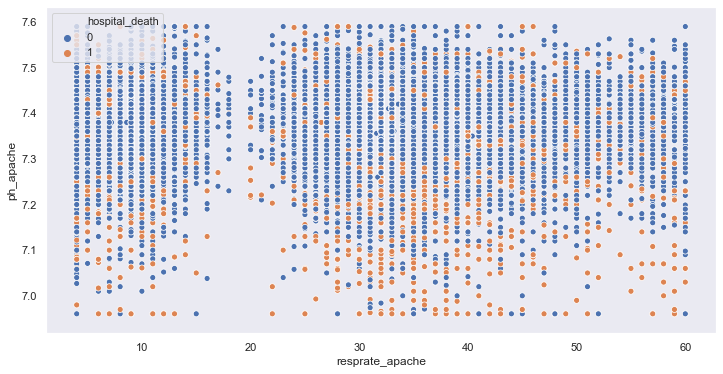

In [54]:
plt.figure(figsize = (12,6))
sns.scatterplot(x = 'resprate_apache', y = 'ph_apache', data = dfa, hue = 'hospital_death')
plt.grid()
plt.legend(loc='upper left')

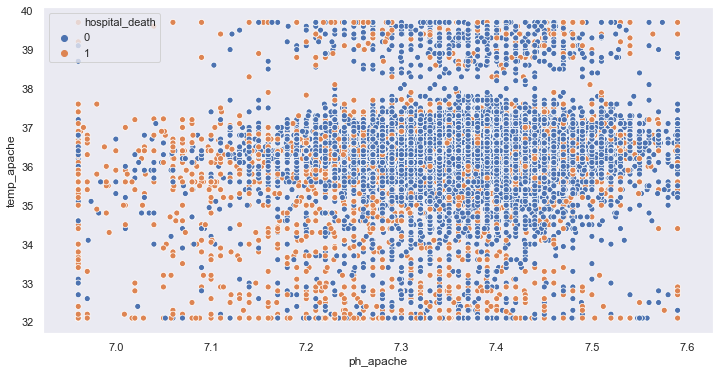

In [55]:
plt.figure(figsize = (12,6))
sns.scatterplot(x = 'ph_apache', y = 'temp_apache', data = dfa, hue = 'hospital_death')
plt.grid()
plt.legend(loc='upper left')

In [56]:
df.h1_lactate_max.mean()

3.0568389057750815

In [57]:
# plt.figure(figsize = (12,6))
dfd = df[df.hospital_death ==1]
dfd.icu_type.value_counts()

Med-Surg ICU    4352
MICU             919
Neuro ICU        623
CCU-CTICU        532
Cardiac ICU      484
SICU             385
CSICU            248
CTICU            236
Name: icu_type, dtype: int64

In [58]:
df[((df.temp_apache <= 38) & ((df.ph_apache < 7.1) | (df.ph_apache < 7.3 )) & (df.temp_apache<35) |((df.ph_apache < 7.1 )) & (df.map_apache < 50) | ((df.ph_apache < 7.2 )) & (df.gcs < 5) | (df.pre_icu_los_days > 40)) | (df.h1_lactate_max > 11) ].hospital_death.value_counts()


1    762
0    447
Name: hospital_death, dtype: int64

In [59]:
df[((df.ph_apache < 7.2) & (df.map_apache <45)) | ((df.ph_apache < 7.2) & (df.map_apache >140)) & (df.gcs < 5)].hospital_death.value_counts()


1    386
0    135
Name: hospital_death, dtype: int64

In [60]:
df.ventilated_apache[(df['ventilated_apache'].isnull())&(df['h1_arterial_pco2_max'].notnull())] = 1
df.ventilated_apache[(df['ventilated_apache'].isnull())&(df['h1_arterial_pco2_max'].isnull())] = 0

In [80]:
df.ventilated_apache[(df['ventilated_apache'].isnull())]

Series([], Name: ventilated_apache, dtype: float64)

In [82]:
df['ventilated_apache'].isnull().sum()

0

In [62]:
df1.head(2)

,Category,Variable Name,Unit of Measure,Data Type,Description,Example
0,identifier,encounter_id,None,integer,Unique identifier associated with a patient unit stay,None
1,identifier,hospital_id,None,integer,Unique identifier associated with a hospital,None


# Drop non_useful features

In [63]:
to_remove=['hospital_id','icu_id','patient_id','encounter_id','apache_4a_hospital_death_prob','apache_4a_icu_death_prob' ]
features = [col for col in df.columns if col not in to_remove]

In [64]:
def drop_correlated_features(df):
    df1 = pd.read_csv('data/WiDS Datathon 2020 Dictionary.csv')
    df1 = df1[(df1['Data Type'] == 'string') | (df1['Data Type'] == 'binary')]
    cat_features = list(df1['Variable Name'].values)
    for c in cat_features:
        if c not in df1.columns or c == 'hospital_death':
            cat_features.remove(c)

    num_feature = [col for col in features if col not in cat_features and df[col].dtype != 'object']
    drop_columns=[]
    corr = df[num_feature].corr()



    columns = np.full((corr.shape[0],), True, dtype=bool)

    for i in range(corr.shape[0]):
        for j in range(i+1, corr.shape[0]):
            if corr.iloc[i,j] >=0.99 :
                if columns[j] == True:
                    columns[j] = False
#                     print('col1: {} col2: {} - Correlation: {}'.format(df[num_feature].columns[i] , df[num_feature].columns[j], corr.iloc[i,j]))
            elif corr.iloc[i,j] <= -0.99:
                if columns[j] == True:
                    columns[j] = False

    drop_columns = df[num_feature].columns[columns == False].values
    return drop_columns

In [65]:
drop_columns = drop_correlated_features(df)

In [66]:
drop_columns

array(['paco2_for_ph_apache', 'd1_diasbp_noninvasive_max',
       'd1_diasbp_noninvasive_min', 'd1_mbp_noninvasive_min',
       'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min',
       'h1_mbp_noninvasive_min', 'h1_sysbp_noninvasive_max',
       'd1_bilirubin_max', 'd1_creatinine_max', 'h1_albumin_min',
       'h1_bilirubin_min', 'h1_bun_min', 'h1_creatinine_min',
       'h1_hco3_min', 'h1_inr_max', 'h1_inr_min', 'h1_platelets_min',
       'h1_wbc_min', 'diff_age', 'diff_height', 'diff_weight',
       'diff_albumin_apache', 'diff_arf_apache', 'diff_bilirubin_apache',
       'diff_bun_apache', 'diff_creatinine_apache', 'diff_fio2_apache',
       'diff_glucose_apache', 'diff_heart_rate_apache',
       'diff_hematocrit_apache', 'diff_intubated_apache',
       'diff_map_apache', 'diff_paco2_apache', 'diff_paco2_for_ph_apache',
       'diff_pao2_apache', 'diff_ph_apache', 'diff_resprate_apache',
       'diff_sodium_apache', 'diff_temp_apache',
       'diff_urineoutput_apache', 'diff_w

In [67]:
features = [col for col in features if col not in drop_columns]

In [68]:
df = df[features]
inv_cols=[s for s in df.columns.tolist() if "invasive" in s]
df.drop(inv_cols,axis=1,inplace=True)

In [69]:
df['icu_type']=df['icu_type'].replace({'CTICU':'CCU-CTICU',
                                              'Cardiac ICU':'CCT-CTICU',
                                              'CTICU':'CCT-CTICU',
                                              'CSICU':'SICU'})

df['hospital_admit_source']= df['hospital_admit_source'].replace({
                                        'Other ICU':"ICU",'ICU to SDU':"SDU",
                                       'Step-Down Unit (SDU)':"SDU",
                                      'Acute Care/Floor':"Floor",
                                      'Other Hospital':"Other"})


binary=[col for col in df.columns if df[col].nunique() == 2 and df[col].dtypes !='object']
categorical = [col for col in df.columns if df[col].dtypes == 'object']
df['apache_3j_diagnosis']= df['apache_3j_diagnosis'].fillna(0).astype(np.int64)
df['apache_2_diagnosis']= df['apache_2_diagnosis'].fillna(0).astype(np.int64)
categorical.append('apache_2_diagnosis')
categorical.append('apache_3j_diagnosis')

In [70]:
for col in binary:
    df[col]= df[col]+1
    df[col].fillna(0,inplace=True)
    df[col]= df[col].astype(np.int8).astype('category')

In [71]:
df['gcs_unable_apache'] = df['gcs_unable_apache'].astype('Int64')
for b in binary:
    df[b] = df[b].astype('Int64')

In [72]:
df.shape

(90051, 148)

In [73]:
missing = ['h1_bilirubin_max', 'h1_lactate_max',
       'h1_lactate_min', 'h1_albumin_max',
       'h1_pao2fio2ratio_min', 'h1_pao2fio2ratio_max', 'h1_arterial_ph_max',
       'h1_arterial_ph_min', 'h1_hco3_max',
       'h1_arterial_pco2_max', 'h1_arterial_pco2_min', 'h1_wbc_max',
       'h1_arterial_po2_min', 'h1_arterial_po2_max',
       'h1_calcium_max', 'h1_calcium_min', 
       'h1_platelets_max', 'h1_bun_max', 'h1_creatinine_max',
       'h1_hematocrit_min', 'h1_hematocrit_max',
       'h1_hemaglobin_min', 'h1_hemaglobin_max', 'h1_sodium_max',
       'h1_sodium_min', 'h1_potassium_min', 'h1_potassium_max']

In [74]:
df = df.drop(columns = missing)

In [75]:
numeric_col =[col for col in df.columns if  df[col].dtypes !='object' and col not in binary]

In [76]:
numeric_col

['age',
 'bmi',
 'height',
 'pre_icu_los_days',
 'readmission_status',
 'weight',
 'albumin_apache',
 'apache_2_diagnosis',
 'apache_3j_diagnosis',
 'bilirubin_apache',
 'bun_apache',
 'creatinine_apache',
 'fio2_apache',
 'gcs_eyes_apache',
 'gcs_motor_apache',
 'gcs_verbal_apache',
 'glucose_apache',
 'heart_rate_apache',
 'hematocrit_apache',
 'map_apache',
 'paco2_apache',
 'pao2_apache',
 'ph_apache',
 'resprate_apache',
 'sodium_apache',
 'temp_apache',
 'urineoutput_apache',
 'wbc_apache',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_heartrate_max',
 'd1_heartrate_min',
 'd1_mbp_max',
 'd1_mbp_min',
 'd1_resprate_max',
 'd1_resprate_min',
 'd1_spo2_max',
 'd1_spo2_min',
 'd1_sysbp_max',
 'd1_sysbp_min',
 'd1_temp_max',
 'd1_temp_min',
 'h1_diasbp_max',
 'h1_diasbp_min',
 'h1_heartrate_max',
 'h1_heartrate_min',
 'h1_mbp_max',
 'h1_mbp_min',
 'h1_resprate_max',
 'h1_resprate_min',
 'h1_spo2_max',
 'h1_spo2_min',
 'h1_sysbp_max',
 'h1_sysbp_min',
 'h1_temp_max',
 'h1_temp_min',
 'd1_a

In [77]:
redundant_features = ['readmission_status', 'apache_2_bodysystem', 'apache_2_diagnosis', 'apache_3j_diagnosis']

In [78]:
df.drop(columns = redundant_features, inplace = True)

In [79]:
m

'h1_lactate_max'

In [80]:
h1_col=[col for col in numeric_col if "h1_" in col]
d1_col=[col for col in numeric_col if "d1_" in col]

hd = list(pd.Series(h1_col).str.replace("h1_",""))
hd
for c in hd:
    df['diff_'+c] =  df['d1_'+c] - df['h1_'+c]


In [81]:
numeric_col.remove('readmission_status')
numeric_col.remove('apache_2_diagnosis')
numeric_col.remove('apache_3j_diagnosis')
categorical.remove('apache_2_bodysystem')
categorical.remove('icu_stay_type')
categorical.remove('apache_2_diagnosis')
categorical.remove('apache_3j_diagnosis')

In [100]:
categorical

['ethnicity',
 'gender',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_type',
 'apache_3j_bodysystem']

In [101]:
binary

['hospital_death',
 'elective_surgery',
 'apache_post_operative',
 'arf_apache',
 'gcs_unable_apache',
 'intubated_apache',
 'ventilated_apache',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis',
 'diff_ventilated_apache']

In [102]:
binary = ['hospital_death',
 'elective_surgery',
 'apache_post_operative',
 'arf_apache',
 'gcs_unable_apache',
 'intubated_apache',
 'ventilated_apache',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis',
 'boolh1_lactate_max']

In [103]:
df.shape

(90051, 116)

In [109]:
df = df.drop(columns = [
 'boolh1_arterial_po2_min',
 'boolh1_albumin_min',
 'boolh1_hematocrit_max',
 'boolh1_hco3_min',
 'boolh1_pao2fio2ratio_max'])

KeyError: "['boolh1_arterial_po2_min' 'boolh1_albumin_min' 'boolh1_hematocrit_max'\n 'boolh1_hco3_min' 'boolh1_pao2fio2ratio_max'] not found in axis"

In [117]:
train, test = train_test_split(df, train_size = .80, random_state = 42, stratify = df.hospital_death)

In [120]:
train.head(2)

,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,weight,albumin_apache,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_glucose_max,h1_glucose_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,gcs,diff_bmi,diff_ventilated_apache,bool_height
59431,1,68.0,35.738127,1,Caucasian,M,172.7,Emergency Department,Accident & Emergency,admit,Neuro ICU,0.153472,106.59,NaN,1,1,NaN,23.0,1.13,NaN,4.0,6.0,1,5.0,112.0,64.0,37.3,1,61.0,NaN,NaN,NaN,10.0,134.0,36.5,963.8784,1,10.21,105.0,50.0,82.0,64.0,114.0,56.0,20.0,10.0,96.0,81.0,154.0,99.0,36.9,36.5,75.0,58.0,82.0,77.0,83.0,67.0,20.0,12.0,96.0,93.0,127.0,99.0,36.7,36.7,NaN,NaN,NaN,23.0,23.0,8.8,8.8,1.13,112.0,112.0,27.0,27.0,12.2,12.2,37.3,37.3,NaN,NaN,NaN,NaN,219.0,219.0,4.5,4.5,134.0,134.0,10.21,10.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1,Trauma,15.0,-8.596865,1,1
91612,1,81.0,32.320002,1,Caucasian,M,182.8,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,0.086806,108.00,3.6,1,1,1.2,33.0,1.30,NaN,4.0,6.0,1,5.0,185.0,94.0,31.0,1,74.0,NaN,NaN,NaN,13.0,137.0,36.3,NaN,1,8.35,74.0,55.0,104.0,69.0,91.0,74.0,24.0,13.0,100.0,88.0,149.0,116.0,36.5,36.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.6,3.6,1.2,33.0,33.0,8.7,8.7,1.30,194.0,92.0,28.0,28.0,10.3,10.3,31.0,31.0,6.7,6.127,NaN,NaN,168.0,168.0,3.4,3.4,137.0,137.0,8.35,8.35,190.0,190.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,2,1,1,1,1,1,Respiratory,15.0,-5.178739,1,1


# Exploration

In [35]:
h1_arterial = [s for s in df.columns.tolist() if "h1_arterial" in s]
d1_arterial = [s for s in df.columns.tolist() if "d1_arterial" in s]

In [36]:
h1_arterial

['h1_arterial_pco2_max',
 'h1_arterial_pco2_min',
 'h1_arterial_ph_max',
 'h1_arterial_ph_min',
 'h1_arterial_po2_max',
 'h1_arterial_po2_min']

In [37]:
train.head(2)

,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,weight,albumin_apache,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_bilirubin_max,h1_bun_max,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,gcs
59226,2,72.0,32.041330,1,Caucasian,F,154.9,SDU,Floor,admit,MICU,0.061111,76.88,2.0,1,1,2.4,26.0,1.64,NaN,4.0,6.0,1,4.0,107.0,99.0,27.9,1,45.0,NaN,NaN,NaN,13.0,135.0,36.6,NaN,1,22.81,95.0,13.0,150.0,77.0,101.0,22.0,40.0,12.0,100.0,38.0,161.0,48.0,36.7,35.8,51.0,39.0,94.0,92.0,59.0,47.0,19.0,16.0,98.0,96.0,85.0,72.0,NaN,NaN,2.0,2.0,2.4,26.0,26.0,7.1,7.1,1.64,132.0,107.0,20.0,20.0,13.7,8.8,43.6,27.9,1.8,1.8,2.6,2.6,81.0,81.0,4.1,4.1,135.0,135.0,22.81,22.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,2,Sepsis,14.0
81334,1,58.0,34.334291,1,Caucasian,M,190.5,Direct Admit,Accident & Emergency,admit,Med-Surg ICU,0.032639,124.60,2.5,1,1,1.2,70.0,2.85,NaN,1.0,1.0,1,1.0,319.0,138.0,37.4,1,47.0,NaN,NaN,NaN,53.0,117.0,36.2,NaN,2,16.20,137.0,14.0,138.0,83.0,144.0,42.0,53.0,17.0,99.0,81.0,161.0,77.0,37.8,36.2,64.0,22.0,128.0,116.0,86.0,42.0,53.0,30.0,98.0,96.0,121.0,96.0,37.8,37.4,2.6,2.5,1.0,70.0,63.0,8.5,8.1,2.44,319.0,212.0,36.0,32.0,11.9,11.9,37.4,37.4,1.4,1.4,2.7,1.9,358.0,358.0,4.3,4.1,123.0,152.0,16.20,16.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,2,1,1,1,1,1,Sepsis,3.0


In [38]:
train.d1_pao2fio2ratio_min.isnull().sum()

52774

In [39]:
(train.ventilated_apache.isnull()).sum()

0

In [40]:
train[(train.ventilated_apache.isnull()) & (train.h1_arterial_po2_max.notnull())  ].shape
# train[(train.ventilated_apache == 1) & (train.h1_pao2fio2ratio_min.isnull()) & (train.h1_arterial_po2_max.isnull())].shape


(0, 141)

In [41]:
print(train.h1_arterial_po2_max.notnull().sum())
print(train.h1_arterial_po2_min.notnull().sum())
print(train.d1_arterial_po2_max.notnull().sum())
print(train.d1_arterial_po2_min.notnull().sum())



print(train.h1_arterial_po2_min.notnull().sum())
print(train.h1_arterial_po2_max.notnull().sum())
print(train.d1_arterial_po2_min.notnull().sum())
print(train.d1_arterial_po2_max.notnull().sum())

print(train.h1_arterial_po2_max.notnull().sum())
print(train.h1_arterial_po2_max.notnull().sum())
print(train.d1_arterial_po2_max.notnull().sum())
print(train.d1_arterial_po2_max.notnull().sum())

print(train.h1_pao2fio2ratio_max.notnull().sum())
print(train.h1_pao2fio2ratio_min.notnull().sum())

print(train.h1_arterial_ph_max.notnull().sum())
print(train.h1_arterial_ph_min.notnull().sum())

12544
12544
25962
25962
12544
12544
25962
25962
12544
12544
25962
25962
9196
9196
12165
12165


## Imputation
Imputation was done based on the type of variable it was. Broadly, there are numerical and categorical variables.

### Numerical variables

In [121]:
numeric_df = train[numeric_col]
numeric_df_test = test[numeric_col]
numeric_df.head(3)

,age,bmi,height,pre_icu_los_days,weight,albumin_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,map_apache,paco2_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_glucose_max,h1_glucose_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,gcs,diff_bmi
59431,68.0,35.738127,172.7,0.153472,106.59,NaN,NaN,23.0,1.13,NaN,4.0,6.0,5.0,112.0,64.0,37.3,61.0,NaN,NaN,NaN,10.0,134.0,36.5,963.8784,10.21,105.0,50.0,82.0,64.0,114.0,56.0,20.0,10.0,96.0,81.0,154.0,99.0,36.9,36.5,75.0,58.0,82.0,77.0,83.0,67.0,20.0,12.0,96.0,93.0,127.0,99.0,36.7,36.7,NaN,NaN,NaN,23.0,23.0,8.8,8.8,1.13,112.0,112.0,27.0,27.0,12.2,12.2,37.3,37.3,NaN,NaN,NaN,NaN,219.0,219.0,4.5,4.5,134.0,134.0,10.21,10.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,-8.596865
91612,81.0,32.320002,182.8,0.086806,108.00,3.6,1.2,33.0,1.30,NaN,4.0,6.0,5.0,185.0,94.0,31.0,74.0,NaN,NaN,NaN,13.0,137.0,36.3,NaN,8.35,74.0,55.0,104.0,69.0,91.0,74.0,24.0,13.0,100.0,88.0,149.0,116.0,36.5,36.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.6,3.6,1.2,33.0,33.0,8.7,8.7,1.30,194.0,92.0,28.0,28.0,10.3,10.3,31.0,31.0,6.7,6.127,NaN,NaN,168.0,168.0,3.4,3.4,137.0,137.0,8.35,8.35,190.0,190.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,-5.178739
50417,63.0,37.015566,172.7,0.209722,110.40,NaN,NaN,9.0,0.80,NaN,4.0,6.0,5.0,336.0,126.0,36.8,73.0,NaN,NaN,NaN,28.0,142.0,36.9,2186.1792,5.90,89.0,56.0,119.0,85.0,110.0,73.0,33.0,16.0,98.0,90.0,147.0,94.0,37.3,36.8,78.0,72.0,119.0,116.0,93.0,90.0,28.0,22.0,95.0,95.0,133.0,126.0,36.9,36.9,NaN,NaN,NaN,9.0,9.0,8.5,8.5,0.80,336.0,225.0,28.0,28.0,11.5,11.5,36.8,36.8,NaN,NaN,NaN,NaN,270.0,270.0,4.5,4.5,142.0,142.0,5.90,5.90,336.0,336.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,-9.874304


In [124]:
train.head(2)

,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,weight,albumin_apache,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_glucose_max,h1_glucose_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,gcs,diff_bmi,diff_ventilated_apache,bool_height
59431,1,68.0,35.738127,1,Caucasian,M,172.7,Emergency Department,Accident & Emergency,admit,Neuro ICU,0.153472,106.59,NaN,1,1,NaN,23.0,1.13,NaN,4.0,6.0,1,5.0,112.0,64.0,37.3,1,61.0,NaN,NaN,NaN,10.0,134.0,36.5,963.8784,1,10.21,105.0,50.0,82.0,64.0,114.0,56.0,20.0,10.0,96.0,81.0,154.0,99.0,36.9,36.5,75.0,58.0,82.0,77.0,83.0,67.0,20.0,12.0,96.0,93.0,127.0,99.0,36.7,36.7,NaN,NaN,NaN,23.0,23.0,8.8,8.8,1.13,112.0,112.0,27.0,27.0,12.2,12.2,37.3,37.3,NaN,NaN,NaN,NaN,219.0,219.0,4.5,4.5,134.0,134.0,10.21,10.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1,Trauma,15.0,-8.596865,1,1
91612,1,81.0,32.320002,1,Caucasian,M,182.8,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,0.086806,108.00,3.6,1,1,1.2,33.0,1.30,NaN,4.0,6.0,1,5.0,185.0,94.0,31.0,1,74.0,NaN,NaN,NaN,13.0,137.0,36.3,NaN,1,8.35,74.0,55.0,104.0,69.0,91.0,74.0,24.0,13.0,100.0,88.0,149.0,116.0,36.5,36.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.6,3.6,1.2,33.0,33.0,8.7,8.7,1.30,194.0,92.0,28.0,28.0,10.3,10.3,31.0,31.0,6.7,6.127,NaN,NaN,168.0,168.0,3.4,3.4,137.0,137.0,8.35,8.35,190.0,190.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,2,1,1,1,1,1,Respiratory,15.0,-5.178739,1,1


In [122]:
binary_df = train[binary]
binary_df_test = test[binary]


binary_df.head(3)

KeyError: "['boolh1_lactate_max'] not in index"

In [ ]:
categorical_df = train[categorical]
categorical_df_test = test[categorical]

categorical_df.isnull().sum()

In [ ]:
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer

In [169]:
imp = IterativeImputer(max_iter=3, verbose=0)
imp.fit(numeric_df)
imputed_df = imp.transform(numeric_df)
imputed_df = pd.DataFrame(imputed_df, columns=numeric_df.columns, index = numeric_df.index)

In [170]:
impt = IterativeImputer(max_iter=3, verbose=0)
impt.fit(numeric_df_test)
imputed_df_test = impt.transform(numeric_df_test)
imputed_df_test = pd.DataFrame(imputed_df_test, columns=numeric_df_test.columns, index = numeric_df_test.index)

In [171]:
for col in categorical:
    categorical_df[col].fillna(categorical_df[col].mode()[0],inplace=True)

In [172]:
for col in categorical:
    categorical_df_test[col].fillna(categorical_df_test[col].mode()[0],inplace=True)

In [173]:
imputed_df.head(2)

,age,bmi,height,pre_icu_los_days,weight,albumin_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,map_apache,paco2_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_glucose_max,h1_glucose_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,gcs
59226,72.0,32.041330,154.9,0.061111,76.88,2.0,2.4,26.0,1.64,0.667819,4.0,6.0,4.0,107.0,99.0,27.9,45.0,40.448252,130.748167,7.325978,13.0,135.0,36.6,190.289657,22.81,95.0,13.0,150.0,77.0,101.0,22.0,40.0,12.0,100.0,38.0,161.0,48.0,36.7,35.8,51.0,39.0,94.0,92.0,59.0,47.0,19.0,16.0,98.0,96.0,85.0,72.0,36.251726,36.201901,2.0,2.0,2.4,26.0,26.0,7.1,7.1,1.64,132.0,107.0,20.0,20.0,13.7,8.8,43.6,27.9,1.8,1.8,2.6,2.6,81.0,81.0,4.1,4.1,135.0,135.0,22.81,22.81,125.719181,123.307087,45.743920,35.831373,7.355025,7.290816,210.688951,104.129804,248.659084,197.668240,14.0
81334,58.0,34.334291,190.5,0.032639,124.60,2.5,1.2,70.0,2.85,0.622663,1.0,1.0,1.0,319.0,138.0,37.4,47.0,55.724735,106.145079,7.377359,53.0,117.0,36.2,1008.737549,16.20,137.0,14.0,138.0,83.0,144.0,42.0,53.0,17.0,99.0,81.0,161.0,77.0,37.8,36.2,64.0,22.0,128.0,116.0,86.0,42.0,53.0,30.0,98.0,96.0,121.0,96.0,37.800000,37.400000,2.6,2.5,1.0,70.0,63.0,8.5,8.1,2.44,319.0,212.0,36.0,32.0,11.9,11.9,37.4,37.4,1.4,1.4,2.7,1.9,358.0,358.0,4.3,4.1,123.0,152.0,16.20,16.20,202.346826,213.497986,58.762166,51.266508,7.386448,7.351720,52.723587,88.404037,194.686721,173.325634,3.0


In [174]:
imputed_df.shape, imputed_df_test.shape

((73370, 92), (18343, 92))

In [175]:
scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(imputed_df)

imputed_df_scaled = pd.DataFrame(scaler.transform(imputed_df), columns=imputed_df.columns.values).set_index([imputed_df.index.values])



In [176]:
scaler1 = MinMaxScaler(copy=True, feature_range=(0,1)).fit(imputed_df_test)

imputed_df_test_scaled = pd.DataFrame(scaler1.transform(imputed_df_test), columns=imputed_df_test.columns.values).set_index([imputed_df_test.index.values])


In [177]:
numeric_df.shape, categorical_df.shape, binary_df.shape

((73370, 92), (73370, 6), (73370, 20))

# Feature selection

# Encoding

## Label encoding
Encode Male as 1 and female 0

In [178]:
# categorical_df['gender']= categorical_df['gender'].apply(lambda x: 1 if x =='M' else 0).astype(str)

In [179]:
categorical_df.dtypes

ethnicity                object
gender                   object
hospital_admit_source    object
icu_admit_source         object
icu_type                 object
apache_3j_bodysystem     object
dtype: object

In [180]:
categorical_df.apache_3j_bodysystem.value_counts()

Cardiovascular          25284
Neurological             9576
Sepsis                   9395
Respiratory              9283
Gastrointestinal         7220
Metabolic                6101
Trauma                   3084
Genitourinary            1740
Musculoskeletal/Skin      936
Hematological             503
Gynecological             248
Name: apache_3j_bodysystem, dtype: int64

## One hot encoding

In [181]:
from sklearn.preprocessing import OneHotEncoder

In [182]:
categorical_df.columns

Index(['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source',
       'icu_type', 'apache_3j_bodysystem'],
      dtype='object')

In [184]:
binary_df.drop(columns=['hospital_death'], inplace = True)
binary_df_test.drop(columns=['hospital_death'], inplace = True)

KeyError: "['hospital_death'] not found in axis"

In [185]:
l = ['ethnicity','gender','hospital_admit_source', 'icu_admit_source','icu_type', 'apache_3j_bodysystem',
 'elective_surgery',
 'apache_post_operative',
 'arf_apache',
 'gcs_unable_apache',
 'intubated_apache',
 'ventilated_apache',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis']

In [186]:
train1 = pd.concat([categorical_df, binary_df], axis =1)
test1 = pd.concat([categorical_df_test, binary_df_test], axis =1)

In [187]:
train1.head(2)

,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_type,apache_3j_bodysystem,elective_surgery,apache_post_operative,arf_apache,gcs_unable_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,boolh1_lactate_max,boolh1_arterial_po2_min,boolh1_albumin_min,boolh1_hematocrit_max,boolh1_hco3_min,boolh1_pao2fio2ratio_max
59226,Caucasian,F,SDU,Floor,MICU,Sepsis,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1
81334,Caucasian,M,Direct Admit,Accident & Emergency,Med-Surg ICU,Sepsis,1,1,1,1,1,2,1,1,2,1,1,1,1,1,1,1,1,1,1,1


In [188]:
train1 = prepare_ravinder.encode(train1, l)
test1 = prepare_ravinder.encode(test1, l)

In [189]:
# categorical_df.to_csv('data/categorical.csv')

In [190]:
numeric_df.shape, categorical_df.shape, binary_df.shape

((73370, 92), (73370, 6), (73370, 20))

In [191]:
imputed_df.shape, categorical_df.shape, binary_df.shape

((73370, 92), (73370, 6), (73370, 20))

In [192]:
train = pd.concat([imputed_df_scaled ,train1], axis =1)
test = pd.concat([imputed_df_test_scaled ,test1], axis =1)


train

,age,bmi,height,pre_icu_los_days,weight,albumin_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,map_apache,paco2_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_glucose_max,h1_glucose_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,gcs,boolh1_lactate_max,boolh1_arterial_po2_min,boolh1_albumin_min,boolh1_hematocrit_max,boolh1_hco3_min,boolh1_pao2fio2ratio_max,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,gender_F,gender_M,hospital_admit_source_Chest Pain Center,hospital_admit_source_Direct Admit,hospital_admit_source_Emergency Department,hospital_admit_source_Floor,hospital_admit_source_ICU,hospital_admit_source_Observation,hospital_admit_source_Operating Room,hospital_admit_source_Other,hospital_admit_source_PACU,hospital_admit_source_Recovery Room,hospital_admit_source_SDU,icu_admit_source_Accident & Emergency,icu_admit_source_Floor,icu_admit_source_Operating Room / Recovery,icu_admit_source_Other Hospital,icu_admit_source_Other ICU,icu_type_CCT-CTICU,icu_type_CCU-CTICU,icu_type_MICU,icu_type_Med-Surg ICU,icu_type_Neuro ICU,icu_type_SICU,apache_3j_bodysystem_Cardiovascular,apache_3j_bodysystem_Gastrointestinal,apache_3j_bodysystem_Genitourinary,apache_3j_bodysystem_Gynecological,apache_3j_bodysystem_Hematological,apache_3j_bodysystem_Metabolic,apache_3j_bodysystem_Musculoskeletal/Skin,apache_3j_bodysystem_Neurological,apache_3j_bodysystem_Respiratory,apache_3j_bodysystem_Sepsis,apache_3j_bodysystem_Trauma,elective_surgery_1,elective_surgery_2,apache_post_operative_1,apache_post_operative_2,arf_apache_0,arf_apache_1,arf_apache_2,gcs_unable_apache_0,gcs_unable_apache_1,gcs_unable_apache_2,intubated_apache_0,intubated_apache_1,intubated_apache_2,ventilated_apache_0,ventilated_apache_1,ventilated_apache_2,aids_0,aids_1,aids_2,cirrhosis_0,cirrhosis_1,cirrhosis_2,diabetes_mellitus_0,diabetes_mellitus_1,diabetes_mellitus_2,hepatic_failure_0,hepatic_failure_1,hepatic_failure_2,immunosuppression_0,immunosuppression_1,immunosuppression_2,leukemia_0,leukemia_1,leukemia_2,lymphoma_0,lymphoma_1,lymphoma_2,solid_tumor_with_metastasis_0,solid_tumor_with_metastasis_1,solid_tumor_with_metastasis_2
59226,0.576353,0.324644,0.182907,0.135887,0.259701,0.310508,0.063528,0.189535,0.117805,0.577864,1.000000,1.0,0.75,0.131160,0.466216,0.287719,0.192948,0.332964,0.418190,0.597601,0.091623,0.439024,0.601202,0.507177,0.492641,0.411765,0.000000,0.773109,0.440000,0.337304,0.000000,0.333333,0.12000,0.988867,0.38,0.500000,0.058824,0.333333,0.661648,0.156325,0.186813,0.406780,0.518519,0.160774,0.143873,0.167082,0.124031,0.942777,0.931105,0.095202,0.148004,0.467496,0.515922,0.235294,0.264706,0.054397,0.180731,0.208920,0.195652,0.333333,0.190923,0.109665,0.290196,0.410054,0.439576,0.675050,0.300496,0.745981,0.348083,0.171525,0.207299,0.295468,0.341479,0.096774,0.115884,0.309524,0.500000,0.345799,0.470046,0.4815

# Modeling

## Baseline

In [193]:
# (complet_df.shape[0]-(complet_df['hospital_death']).sum())/complet_df.shape[0]

## Logist regression

### Building a Model

In [194]:
from sklearn.linear_model import LogisticRegression

In [112]:
# param = ['height',
#  'temp_apache',
#  'd1_diasbp_max',
#  'd1_diasbp_min',
#  'd1_heartrate_max',
#  'd1_heartrate_min',
#  'd1_mbp_max',
#  'd1_mbp_min',
#  'd1_spo2_max',
#  'd1_spo2_min',
#  'd1_sysbp_max',
#  'd1_sysbp_min',
#  'd1_temp_max',
#  'd1_temp_min']
# for p in param:  
#     df['bool_'+ p] = np.where(pd.notnull(df[p]), 1,0)

In [196]:
train2, test2 = train_test_split(df, train_size = .80, random_state = 42, stratify = df.hospital_death)

In [197]:
y = train2[['hospital_death']]
y['hospital_death'] = y['hospital_death']-1
X = train

y_test = test2[['hospital_death']]
y_test['hospital_death'] = y_test['hospital_death']-1
X_test = test

In [198]:
y['hospital_death'] = y['hospital_death'].astype(int)
y_test['hospital_death'] = y_test['hospital_death'].astype(int)

In [199]:
X.shape, y.shape

((73370, 179), (73370, 1))

In [200]:
logit = LogisticRegression(C = 0.1, class_weight = 'balanced',penalty = 'l2', max_iter=1000)
logit.fit(X, y)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [208]:
y_pred = logit.predict(X)

In [202]:
y_pred_test = logit.predict(X)

In [203]:
X.columns

Index(['age', 'bmi', 'height', 'pre_icu_los_days', 'weight', 'albumin_apache',
       'bilirubin_apache', 'bun_apache', 'creatinine_apache', 'fio2_apache',
       ...
       'immunosuppression_2', 'leukemia_0', 'leukemia_1', 'leukemia_2',
       'lymphoma_0', 'lymphoma_1', 'lymphoma_2',
       'solid_tumor_with_metastasis_0', 'solid_tumor_with_metastasis_1',
       'solid_tumor_with_metastasis_2'],
      dtype='object', length=179)

In [204]:
feature_imp = pd.DataFrame(logit.coef_[0], index = X.columns).reset_index()

In [205]:
feature_imp.columns = ['feature', 'coeff']
# feature_imp.sort_values('coeff').tail(100)

### AUC Roc score

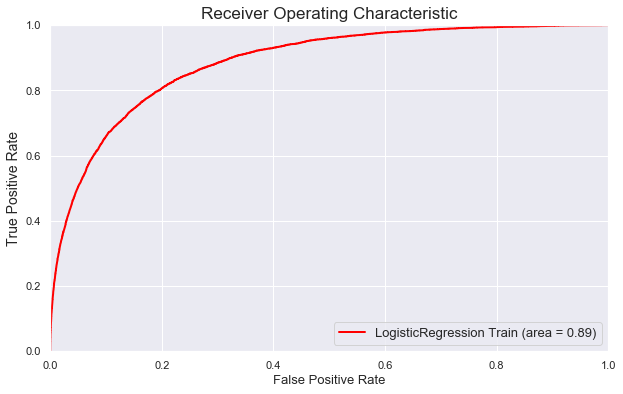

In [210]:
plt.figure(figsize=(10,6))

y_pred = logit.predict_proba(X)[:,1]
fpr, tpr, thresholds = roc_curve(y, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression Train (area = %0.2f)' % auc(fpr, tpr))
         


# y_pred = knn.predict_proba(X_validate_scaled)[:,1]
# fpr, tpr, thresholds = roc_curve(y_validate, y_pred)
# plt.plot(fpr, tpr, color='yellow', lw=3, label='KNN (area = %0.2f)' % auc(fpr, tpr))


# y_pred = clf.predict_proba(X_validate_scaled)[:,1]
# fpr, tpr, thresholds = roc_curve(y_validate, y_pred)
# plt.plot(fpr, tpr, color='brown', lw=2, label='RandomForest (area = %0.2f)' % auc(fpr, tpr))

# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

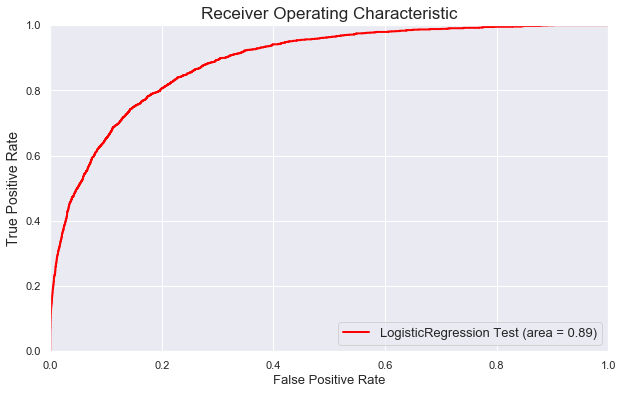

In [207]:
plt.figure(figsize=(10,6))

y_pred_test = logit.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression Test (area = %0.2f)' % auc(fpr, tpr))
         


# y_pred = knn.predict_proba(X_validate_scaled)[:,1]
# fpr, tpr, thresholds = roc_curve(y_validate, y_pred)
# plt.plot(fpr, tpr, color='yellow', lw=3, label='KNN (area = %0.2f)' % auc(fpr, tpr))


# y_pred = clf.predict_proba(X_validate_scaled)[:,1]
# fpr, tpr, thresholds = roc_curve(y_validate, y_pred)
# plt.plot(fpr, tpr, color='brown', lw=2, label='RandomForest (area = %0.2f)' % auc(fpr, tpr))

# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

## Decision Tree

### Building a model

In [84]:
from sklearn.tree import DecisionTreeClassifier


In [85]:
dt = DecisionTreeClassifier(max_depth=8, random_state=42, class_weight={1:2})
dt.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight={1: 2}, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [315]:
X = missing_df
y = df[['hospital_death']]

In [318]:
dt = DecisionTreeClassifier(max_depth=5, random_state=42, class_weight={1:2})
dt.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight={1: 2}, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [320]:
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from graphviz import Graph

dot_data = export_graphviz(dt, out_file=None) 
graph = graphviz.Source(dot_data) 

graph.render('bool_tree', view=True)

'bool_tree.pdf'

In [238]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')



In [239]:
knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
y_pred = knn.predict(X)

### Auc Roc score

In [86]:
lr_probs = dt.predict_proba(X)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

lr_probs_test = dt.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs_test = lr_probs_test[:, 1]


In [87]:
# calculate scores
# ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(y, lr_probs)
lr_auc_test = roc_auc_score(y_test, lr_probs_test)


# summarize scores
print('Logistic: ROC AUC=%.3f' % (lr_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc_test))


# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y, lr_probs)
lr_fpr_test, lr_tpr_test, _ = roc_curve(y, lr_probs_test)


# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Decision Tree Train')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Decision Tree Test')


# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Logistic: ROC AUC=0.880
Logistic: ROC AUC=0.759


ValueError: Found input variables with inconsistent numbers of samples: [73370, 18343]

#  Some_thing to do later